In [9]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from scipy.special import gamma

In [10]:
def simulate_cpu(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    np.random.seed(42)
    lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m     = M / N
    pos   = np.random.randn(N, 3)
    vel   = np.zeros((N, 3))

    def W(x, y, z, h):
        r = np.sqrt(x**2 + y**2 + z**2)
        return (1.0/(h*np.sqrt(np.pi)))**3 * np.exp(-r**2/h**2)

    def gradW(x, y, z, h):
        r = np.sqrt(x**2 + y**2 + z**2)
        n_val = -2 * np.exp(-r**2/h**2) / (h**5 * (np.pi)**(3/2))
        return n_val*x, n_val*y, n_val*z

    def getPairwiseSeparations(ri, rj):
        M_local = ri.shape[0]
        N_local = rj.shape[0]
        rix = ri[:,0].reshape((M_local, 1))
        riy = ri[:,1].reshape((M_local, 1))
        riz = ri[:,2].reshape((M_local, 1))
        rjx = rj[:,0].reshape((N_local, 1))
        rjy = rj[:,1].reshape((N_local, 1))
        rjz = rj[:,2].reshape((N_local, 1))
        dx = rix - rjx.T
        dy = riy - rjy.T
        dz = riz - rjz.T
        return dx, dy, dz

    def getDensity(r, pos, m, h):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        rho = np.sum(m * W(dx, dy, dz, h), axis=1).reshape((-1, 1))
        return rho

    def getPressure(rho, k, n):
        return k * rho**(1+1/n)

    def getAcc(pos, vel, m, h, k, n, lmbda, nu):
        rho = getDensity(pos, pos, m, h)
        P   = getPressure(rho, k, n)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape((-1, 1))
        ay = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape((-1, 1))
        az = - np.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape((-1, 1))
        a = np.hstack((ax, ay, az))
        a -= lmbda * pos
        a -= nu * vel
        return a

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt  = int(np.ceil(tEnd/dt))

    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2
        # drift
        pos += vel * dt
        # update acceleration
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        # (1/2) kick
        vel += acc * dt/2
        t += dt

    return pos, vel

def simulate_gpu(N):
    # Simulation parameters
    t     = 0     # initial time
    tEnd  = 12    # end time
    dt    = 0.04  # timestep
    M     = 2     # star mass
    R     = 0.75  # star radius
    h     = 0.1   # smoothing length
    k     = 0.1   # equation of state constant
    n     = 1     # polytropic index
    nu    = 1     # damping factor

    cp.random.seed(42)
    lmbda = 2*k*(1+n)*cp.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2
    m     = M / N
    pos   = cp.random.randn(N, 3)
    vel   = cp.zeros((N, 3))

    def W(x, y, z, h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        return (1.0/(h*cp.sqrt(cp.pi)))**3 * cp.exp(-r**2/h**2)

    def gradW(x, y, z, h):
        r = cp.sqrt(x**2 + y**2 + z**2)
        n_val = -2 * cp.exp(-r**2/h**2) / (h**5 * (cp.pi)**(3/2))
        return n_val*x, n_val*y, n_val*z

    def getPairwiseSeparations(ri, rj):
        M_local = ri.shape[0]
        N_local = rj.shape[0]
        rix = ri[:,0].reshape((M_local, 1))
        riy = ri[:,1].reshape((M_local, 1))
        riz = ri[:,2].reshape((M_local, 1))
        rjx = rj[:,0].reshape((N_local, 1))
        rjy = rj[:,1].reshape((N_local, 1))
        rjz = rj[:,2].reshape((N_local, 1))
        dx = rix - rjx.T
        dy = riy - rjy.T
        dz = riz - rjz.T
        return dx, dy, dz

    def getDensity(r, pos, m, h):
        dx, dy, dz = getPairwiseSeparations(r, pos)
        rho = cp.sum(m * W(dx, dy, dz, h), axis=1).reshape((-1, 1))
        return rho

    def getPressure(rho, k, n):
        return k * rho**(1+1/n)

    def getAcc(pos, vel, m, h, k, n, lmbda, nu):
        rho = getDensity(pos, pos, m, h)
        P   = getPressure(rho, k, n)
        dx, dy, dz = getPairwiseSeparations(pos, pos)
        dWx, dWy, dWz = gradW(dx, dy, dz, h)
        ax = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWx, axis=1).reshape((-1, 1))
        ay = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWy, axis=1).reshape((-1, 1))
        az = - cp.sum(m * (P/rho**2 + (P.T)/(rho.T**2)) * dWz, axis=1).reshape((-1, 1))
        a = cp.hstack((ax, ay, az))
        a -= lmbda * pos
        a -= nu * vel
        return a

    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
    Nt  = int(cp.ceil(tEnd/dt))

    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2
        # drift
        pos += vel * dt
        # update acceleration
        acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)
        # (1/2) kick
        vel += acc * dt/2
        t += dt

    return pos, vel

N=400: CPU avg = 3.1636s (std: 0.4080s), GPU avg = 0.7068s (std: 0.0182s)
N=1000: CPU avg = 20.7164s (std: 0.1592s), GPU avg = 2.8838s (std: 0.0127s)
N=1600: CPU avg = 73.6636s (std: 0.1852s), GPU avg = 7.0074s (std: 0.0055s)
N=2200: CPU avg = 155.0075s (std: 0.2223s), GPU avg = 13.0562s (std: 0.0096s)


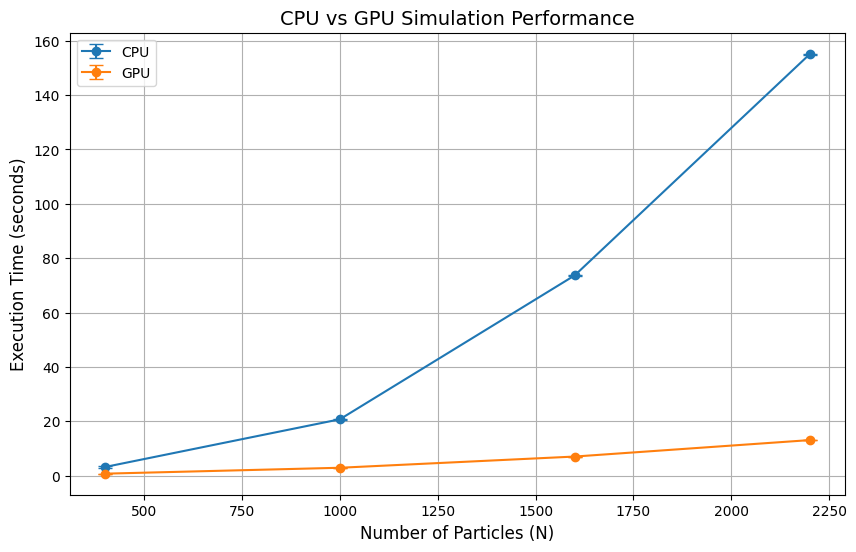

In [12]:
# Define the range of particle counts and number of trials per configuration
particle_counts = [400, 1000, 1600, 2200]
num_trials = 5

cpu_avg_times = []
cpu_std_times = []
gpu_avg_times = []
gpu_std_times = []

for N_val in particle_counts:
    cpu_times = []
    gpu_times = []

    # Run multiple trials for each dataset size
    for trial in range(num_trials):
        # Time CPU simulation
        start_cpu = time.perf_counter()
        simulate_cpu(N=N_val)
        end_cpu = time.perf_counter()
        cpu_times.append(end_cpu - start_cpu)

        # Time GPU simulation (include synchronization)
        start_gpu = time.perf_counter()
        simulate_gpu(N=N_val)
        cp.cuda.Device().synchronize()  # ensure all GPU operations finish
        end_gpu = time.perf_counter()
        gpu_times.append(end_gpu - start_gpu)

    cpu_avg = np.mean(cpu_times)
    cpu_std = np.std(cpu_times)
    gpu_avg = np.mean(gpu_times)
    gpu_std = np.std(gpu_times)

    cpu_avg_times.append(cpu_avg)
    cpu_std_times.append(cpu_std)
    gpu_avg_times.append(gpu_avg)
    gpu_std_times.append(gpu_std)

    print(f"N={N_val}: CPU avg = {cpu_avg:.4f}s (std: {cpu_std:.4f}s), GPU avg = {gpu_avg:.4f}s (std: {gpu_std:.4f}s)")

# Plot the performance results with error bars
plt.figure(figsize=(10,6))
plt.errorbar(particle_counts, cpu_avg_times, yerr=cpu_std_times, fmt='-o', capsize=5, label='CPU')
plt.errorbar(particle_counts, gpu_avg_times, yerr=gpu_std_times, fmt='-o', capsize=5, label='GPU')
plt.xlabel('Number of Particles (N)', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('CPU vs GPU Simulation Performance', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()